In [ ]:
! pip install fukuML

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from talib import RSI, BBANDS,WILLR,MACD
#import re
import talib as ta
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
import numpy as np
from numpy import dot, exp
from scipy.spatial.distance import cdist

In [129]:
class LSSVM:
    'Class that implements the Least-Squares Support Vector Machine.'
    
    def __init__(self, gamma=1, kernel='rbf', **kernel_params): 
        self.gamma = gamma
        
        self.x        = None
        self.y        = None
        self.y_labels = None
        
        # model params
        self.alpha = None
        self.b     = None
        
        self.kernel = LSSVM.get_kernel(kernel, **kernel_params)
        
           
    @staticmethod
    def get_kernel(name, **params):
        
        def linear(x_i, x_j):                           
            return dot(x_i, x_j.T)
        
        def poly(x_i, x_j, d=params.get('d',3)):        
            return ( dot(x_i, x_j.T) + 1 )**d
        
        def rbf(x_i, x_j, sigma=params.get('sigma',1)):
            if x_i.ndim==x_i.ndim and x_i.ndim==2: # both matrices
                return exp( -cdist(x_i,x_j)**2 / sigma**2 )
            
            else: # both vectors or a vector and a matrix
                return exp( -( dot(x_i,x_i.T) + dot(x_j,x_j.T)- 2*dot(x_i,x_j) ) / sigma**2 )
#             temp = x_i.T - X
#             return exp( -dot(temp.temp) / sigma**2 )
                
        kernels = {'linear': linear, 'poly': poly, 'rbf': rbf}
                
        if kernels.get(name) is None: 
            raise KeyError("Kernel '{}' is not defined, try one in the list: {}.".format(name, list(kernels.keys())))
        else: return kernels[name]
        
    
    def opt_params(self, X, y_values):
        sigma = np.multiply( y_values*y_values.T, self.kernel(X,X))
        A_cross = np.linalg.pinv(np.block([[0,y_values.T],[y_values,   sigma + self.gamma**-1 * np.eye(len(y_values))]]))
        B = np.array([0]+[1]*len(y_values))
        solution = dot(A_cross, B)
        b = solution[0]
        alpha = solution[1:]
        
        return (b, alpha)
            
    
    def fit(self, X, Y, verboses=0):
        self.x = X
        self.y = Y
        self.y_labels = np.unique(Y, axis=0)
        y_values = np.where((Y == self.y_labels[0]).all(axis = 1),-1,+1)[:,np.newaxis] # making it a column vector
        self.b, self.alpha = self.opt_params(X, y_values)
        
        #if len(self.y_labels)==2: # binary classification
            # converting to -1/+1
            
    def predict(self, X):
        K = self.kernel(self.x, X)
        y_values = np.where((self.y == self.y_labels[0]).all(axis =1),-1,+1)[:,np.newaxis] # making it a column vector
        Y = np.sign( dot( np.multiply(self.alpha, y_values.flatten()), K ) + self.b)
        y_pred_labels = np.where(Y==-1, self.y_labels[0],self.y_labels[1])
        
        #if len(self.y_labels)==2: # binary classification
            
            
        return y_pred_labels

In [94]:
stock_data= pd.read_csv('india.csv',parse_dates=['Date'])
stock_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2020-06-12,"9,972.90","9,544.95","9,996.05","9,544.35",796.31K,0.72%
1,2020-06-11,"9,902.00","10,094.10","10,112.05","9,885.05",715.45K,-2.12%
2,2020-06-10,"10,116.15","10,072.60","10,148.75","10,036.85",632.38K,0.69%
3,2020-06-09,"10,046.65","10,181.15","10,291.15","10,021.45",754.22K,-1.19%
4,2020-06-08,"10,167.45","10,326.75","10,328.50","10,120.25",936.49K,0.25%


In [95]:
stock_data= stock_data.set_index(pd.DatetimeIndex(stock_data['Date']))
stock_data

,Date,Price,Open,High,Low,Vol.,Change %
Date,,,,,,,
2020-06-12,2020-06-12,"9,972.90","9,544.95","9,996.05","9,544.35",796.31K,0.72%
2020-06-11,2020-06-11,"9,902.00","10,094.10","10,112.05","9,885.05",715.45K,-2.12%
2020-06-10,2020-06-10,"10,116.15","10,072.60","10,148.75","10,036.85",632.38K,0.69%
2020-06-09,2020-06-09,"10,046.65","10,181.15","10,291.15","10,021.45",754.22K,-1.19%
2020-06-08,2020-06-08,"10,167.45","10,326.75","10,328.50","10,120.25",936.49K,0.25%
...,...,...,...,...,...,...,...
2010-05-19,2010-05-19,"4,919.65","5,065.10","5,065.10","4,908.15",212.95M,-2.89%
2010-05-18,2010-05-18,"5,066.20","5,059.55","5,105.20","5,024.25",137.03M,0.12%
2010-05-17,2010-05-17,"5,059.90","5,093.90","5,094.55","4,966.25",169.31M,-0.66%


In [96]:
stock_data = stock_data.iloc[::-1]
stock_data

,Date,Price,Open,High,Low,Vol.,Change %
Date,,,,,,,
2010-05-13,2010-05-13,"5,178.90","5,157.55","5,212.70","5,147.95",179.38M,0.43%
2010-05-14,2010-05-14,"5,093.50","5,180.55","5,192.75","5,070.95",144.38M,-1.65%
2010-05-17,2010-05-17,"5,059.90","5,093.90","5,094.55","4,966.25",169.31M,-0.66%
2010-05-18,2010-05-18,"5,066.20","5,059.55","5,105.20","5,024.25",137.03M,0.12%
2010-05-19,2010-05-19,"4,919.65","5,065.10","5,065.10","4,908.15",212.95M,-2.89%
...,...,...,...,...,...,...,...
2020-06-08,2020-06-08,"10,167.45","10,326.75","10,328.50","10,120.25",936.49K,0.25%
2020-06-09,2020-06-09,"10,046.65","10,181.15","10,291.15","10,021.45",754.22K,-1.19%
2020-06-10,2020-06-10,"10,116.15","10,072.60","10,148.75","10,036.85",632.38K,0.69%


# Data Cleaning

In [97]:
stock_data.iloc[:,1:5]=stock_data.iloc[:,1:5].replace({',':''},regex=True).astype(float)
stock_data.iloc[:,6:7]=stock_data.iloc[:,6:7].replace({'%':''},regex=True).astype(float)
stock_data['Vol.']= stock_data.apply(lambda x : float(x['Vol.'].replace('K','').replace('M','')),axis=1)


Text(0.5, 0, 'Price')

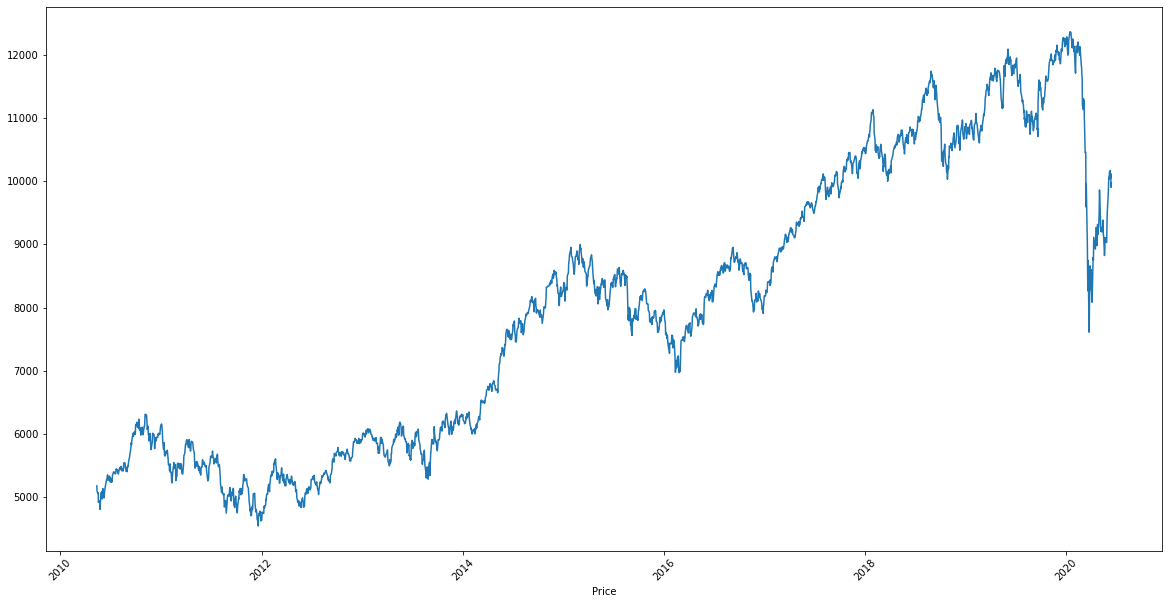

In [98]:
plt.figure(figsize=(20,10))
plt.plot(stock_data['Price'],label='Price')
plt.xticks(rotation=45)
plt.xlabel('Price')

In [99]:
stock_data = stock_data.drop(['Date','Vol.','Change %'],axis =1)

In [100]:
#

In [101]:
close = np.array(stock_data['Price']).astype(float)
high =np.array(stock_data['High']).astype(float)
low =np.array(stock_data['Low']).astype(float)

In [102]:
macd, macdsignal, macdhist = MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
stock_data['MACD'] =macd
stock_data['MACD_signal']=macdsignal
stock_data['MACD_hist']=macdhist
stock_data['MACSIGNAL']=stock_data.apply(lambda x: 1 if x['MACD']> x['MACD_signal'] else -1,axis =1)
#stock_data['MACSIGNAL']=macsignal
stock_data

,Price,Open,High,Low,MACD,MACD_signal,MACD_hist,MACSIGNAL
Date,,,,,,,,
2010-05-13,5178.90,5157.55,5212.70,5147.95,NaN,NaN,NaN,-1
2010-05-14,5093.50,5180.55,5192.75,5070.95,NaN,NaN,NaN,-1
2010-05-17,5059.90,5093.90,5094.55,4966.25,NaN,NaN,NaN,-1
2010-05-18,5066.20,5059.55,5105.20,5024.25,NaN,NaN,NaN,-1
2010-05-19,4919.65,5065.10,5065.10,4908.15,NaN,NaN,NaN,-1
...,...,...,...,...,...,...,...,...
2020-06-08,10167.45,10326.75,10328.50,10120.25,233.199789,123.673394,109.526395,1
2020-06-09,10046.65,10181.15,10291.15,10021.45,238.602987,146.659313,91.943674,1
2020-06-10,10116.15,10072.60,10148.75,10036.85,245.661299,166.459710,79.201589,1


In [103]:
RSI = ta.RSI(close,timeperiod = 14)
stock_data['RSI']= RSI

In [104]:
willR = ta.WILLR(high,low,close,timeperiod=14)
stock_data['WILLR']=willR
stock_data['WILLR_OB']=stock_data.apply(lambda x : -1 if x['WILLR']>-20 else 0,axis=1)
stock_data['WILLR_OS']=stock_data.apply(lambda x : 1 if x['WILLR']>-80 else 0,axis=1)
stock_data['WILLR_SIGN']=stock_data.apply(lambda x:x['WILLR_OB']+x['WILLR_OS'],axis=1)

In [105]:
up, mid, low = BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
stock_data['bb_up'] = up;
stock_data['bb_mid'] = mid;
stock_data['bb_low'] = low;

In [106]:
stock_data = stock_data.dropna()

In [107]:
stock_data

,Price,Open,High,Low,MACD,MACD_signal,MACD_hist,MACSIGNAL,RSI,WILLR,WILLR_OB,WILLR_OS,WILLR_SIGN,bb_up,bb_mid,bb_low
Date,,,,,,,,,,,,,,,,
2010-06-29,5256.15,5333.55,5334.15,5235.80,84.028470,83.636250,0.392221,1,52.713948,-29.960721,0,1,1.0,5429.548639,5192.4175,4955.286361
2010-06-30,5312.50,5254.25,5320.35,5210.00,82.598727,83.428745,-0.830018,-1,56.456214,-18.836806,-1,1,0.0,5435.748032,5207.0500,4978.351968
2010-07-01,5251.40,5312.05,5312.55,5232.10,75.663188,81.875634,-6.212446,-1,51.680279,-46.776156,0,1,1.0,5439.113368,5214.0950,4989.076632
2010-07-02,5237.10,5251.25,5277.25,5225.60,68.226361,79.145779,-10.919418,-1,50.601362,-66.249361,0,1,1.0,5441.437123,5219.1750,4996.912877
2010-07-05,5235.90,5237.00,5252.75,5225.85,61.526553,75.621934,-14.095381,-1,50.506074,-81.679151,0,0,0.0,5434.674003,5229.2700,5023.865997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-08,10167.45,10326.75,10328.50,10120.25,233.199789,123.673394,109.526395,1,68.513729,-10.931985,-1,1,0.0,10302.303313,9431.6600,8561.016687
2020-06-09,10046.65,10181.15,10291.15,10021.45,238.602987,146.659313,91.943674,1,64.069782,-19.395795,-1,1,0.0,10377.424345,9472.0325,8566.640655
2020-06-10,10116.15,10072.60,10148.75,10036.85,245.661299,166.459710,79.201589,1,65.457950,-15.614545,-1,1,0.0,10455.603616,9518.0125,8580.421384


In [108]:
stock_data['up_and_downs']= stock_data['Price'].shift(-1)- stock_data['Price']
stock_data['Direction'] = stock_data['up_and_downs'].apply(lambda x: 1 if x>0 else -1)



C:\Users\Acer\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [109]:
stock_data

,Price,Open,High,Low,MACD,MACD_signal,MACD_hist,MACSIGNAL,RSI,WILLR,WILLR_OB,WILLR_OS,WILLR_SIGN,bb_up,bb_mid,bb_low,up_and_downs,Direction
Date,,,,,,,,,,,,,,,,,,
2010-06-29,5256.15,5333.55,5334.15,5235.80,84.028470,83.636250,0.392221,1,52.713948,-29.960721,0,1,1.0,5429.548639,5192.4175,4955.286361,56.35,1
2010-06-30,5312.50,5254.25,5320.35,5210.00,82.598727,83.428745,-0.830018,-1,56.456214,-18.836806,-1,1,0.0,5435.748032,5207.0500,4978.351968,-61.10,-1
2010-07-01,5251.40,5312.05,5312.55,5232.10,75.663188,81.875634,-6.212446,-1,51.680279,-46.776156,0,1,1.0,5439.113368,5214.0950,4989.076632,-14.30,-1
2010-07-02,5237.10,5251.25,5277.25,5225.60,68.226361,79.145779,-10.919418,-1,50.601362,-66.249361,0,1,1.0,5441.437123,5219.1750,4996.912877,-1.20,-1
2010-07-05,5235.90,5237.00,5252.75,5225.85,61.526553,75.621934,-14.095381,-1,50.506074,-81.679151,0,0,0.0,5434.674003,5229.2700,5023.865997,53.15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-08,10167.45,10326.75,10328.50,10120.25,233.199789,123.673394,109.526395,1,68.513729,-10.931985,-1,1,0.0,10302.303313,9431.6600,8561.016687,-120.80,-1
2020-06-09,10046.65,10181.15,10291.15,10021.45,238.602987,146.659313,91.943674,1,64.069782,-19.395795,-1,1,0.0,10377.424345,9472.0325,8566.640655,69.50,1
2020-06-10,10116.15,10072.60,10148.75,10036.85,245.661299,166.459710,79.201589,1,65.457950,-15.614545,-1,1,0.0,10455.603616,9518.0125,8580.421384,-214.15,-1


In [110]:
feature_data = stock_data[['Price','MACD','RSI','WILLR','Direction']]

In [111]:
X = feature_data.drop(['Direction'],axis =1 )
y = feature_data.Direction

In [112]:
 X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,shuffle = False)

In [113]:
def Scaler(x):
    a=x-x.min()
    b=x.max()-x.min()
    c=-1+2*a/b
    return np.array(c)

In [114]:
X_train = Scaler(X_train)
X_test = Scaler(X_test)

In [131]:
print('linear kernel')
lssvm = LSSVM(gamma=1, kernel='linear')
lssvm.fit(X_train, y_train)
lssvm.predict(X_test)

linear kernel


ValueError: No axis named 1 for object type <class 'pandas.core.series.Series'>